In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from astropy.convolution import Gaussian2DKernel, convolve
from glob import glob
import os

import ar_analysis as ara
import processing as arp

## Path and experiment

In [2]:
base_path = '/archive/Ming.Zhao/awg/2022.03/'
year = 2011
# 
loc_lat = 37.05
loc_lon = -119.2#

## Load 1 year of model data

In [3]:
model_data = arp.load_model_data(
    base_path, year, 
    exp_name='c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', 
    variables=['ts', 'prw', 'pr', 'prsn', 'ivtx', 'ivty', 'mrro', 'mrsos', 'mrso', 'snw', 'evap_land', 'precip'], ar_analysis=True)
model_data['pr'] = model_data.pr * 86400
model_data['precip'] = model_data.precip * 86400
model_data['prsn'] = model_data.prsn * 86400
model_data['mrro'] = model_data.mrro * 86400
model_data['evap_land'] = model_data.evap_land * 86400
model_data = arp.sel_na_westcoast(model_data)

Loading model data for year 2011
exp_name: c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020


/home/Marc.Prange/work/AR-analysis/processing.py:73: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data['time'] = np.array(data.time.values, dtype='datetime64[1D]')
/home/Marc.Prange/work/AR-analysis/processing.py:73: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; i

## Load 1 year of Obs data

In [4]:
era5_data = arp.load_era5_data(base_path, year, ['ivtx', 'ivty', 'prw'], ar_analysis=True)
era5_data = arp.sel_na_westcoast(era5_data)
era5_data['pr'] = era5_data.pr * 86400

/home/Marc.Prange/work/AR-analysis/processing.py:99: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data['time'] = np.array(data.time.values, dtype='datetime64[1D]')
/home/Marc.Prange/work/AR-analysis/processing.py:99: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; i

In [3]:
sharc_data = arp.load_daily_sharc_data(year='all_years', exp_name='providence_lm4sharc_ksat0016_angle087rad_ep26_114y_surfrunoff')
sharc_data['lprec'] = sharc_data.lprec * 86400
sharc_data['fprec'] = sharc_data.fprec * 86400
sharc_data['reach_discharge'] = sharc_data.reach_discharge * 86400
sharc_data['tran'] = sharc_data.tran * 86400
sharc_data['evap'] = sharc_data.evap * 86400
sharc_data['gtos'] = sharc_data.gtos * 86400
sharc_data['gw_stream_flux'] = sharc_data.gw_stream_flux * 86400

sharc_data_yearly = sharc_data.groupby('time.year').mean()

Loading sharc atmos data for year all_years...
Loading sharc ptid data for year all_years...


In [22]:
model_data_yearly = xr.open_mfdataset(
    '/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
    'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_na_*.nc').load().groupby('time.year').mean()

KeyError: "not all values found in index 'lon'. Try setting the `method` keyword argument (example: method='nearest')."

In [27]:
model_data_yearly_providence = model_data_yearly.sel({'lon': loc_lon, 'lat': loc_lat}, method='nearest')
model_data_yearly_portland = model_data_yearly.sel({'lon': -122.678, 'lat': 45.515}, method='nearest')

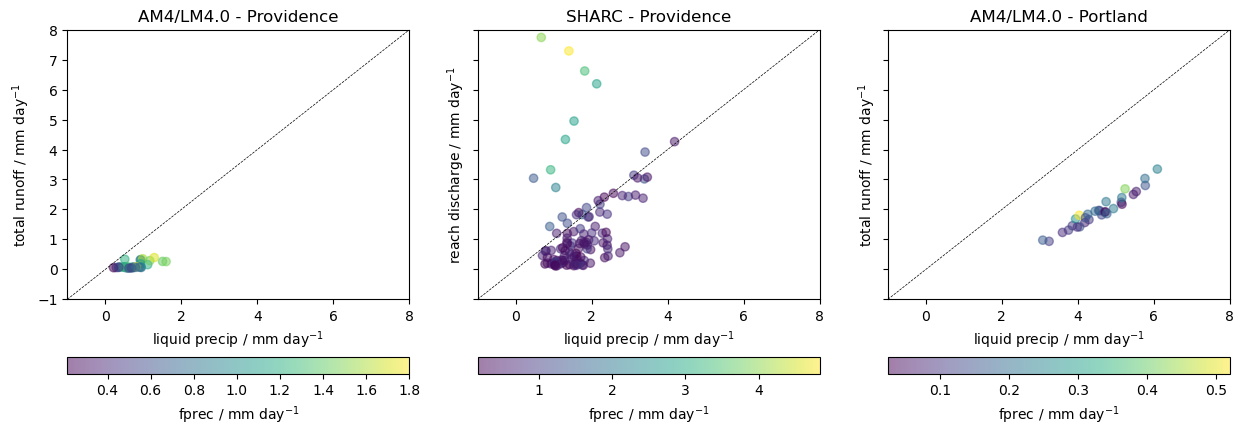

In [34]:

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 5))
axs[0].plot(np.arange(-1, 9), np.arange(-1, 9), 'k--', lw=0.5)
s1 = axs[0].scatter(
    (model_data_yearly_providence.pr - model_data_yearly_providence.prsn)*86400, 
    model_data_yearly_providence.mrro*86400,
    c=model_data_yearly_providence.prsn*86400,
    alpha=0.5)
plt.colorbar(s1, orientation='horizontal', label='fprec / mm day$^{-1}$')
axs[1].plot(np.arange(-1, 9), np.arange(-1, 9), 'k--', lw=0.5)
s2 = axs[1].scatter(
    sharc_data_yearly.lprec,
    sharc_data_yearly.reach_discharge.sel(ptid=1),
    c=(sharc_data_yearly.fprec),
    alpha=0.5)
plt.colorbar(s2, orientation='horizontal', label='fprec / mm day$^{-1}$')
axs[2].plot(np.arange(-1, 9), np.arange(-1, 9), 'k--', lw=0.5)
s3 = axs[2].scatter(
    (model_data_yearly_portland.pr - model_data_yearly_portland.prsn)*86400, 
    model_data_yearly_portland.mrro*86400,
    c=model_data_yearly_portland.prsn*86400,
    alpha=0.5)
plt.colorbar(s3, orientation='horizontal', label='fprec / mm day$^{-1}$')
axs[0].set(
    xlabel='liquid precip / mm day$^{-1}$', ylabel='total runoff / mm day$^{-1}$',
    title='AM4/LM4.0 - Providence')
axs[1].set(
    xlim=[-1, 8], ylim=[-1, 8], 
    xlabel='liquid precip / mm day$^{-1}$', ylabel='reach discharge / mm day$^{-1}$',
    title='SHARC - Providence')
axs[2].set(
    xlabel='liquid precip / mm day$^{-1}$', ylabel='total runoff / mm day$^{-1}$',
    title='AM4/LM4.0 - Portland')
plt.savefig(
    'plots/runoff/annual_scatter_precip_runoff_LM4_SHARC_providence_portland.png', 
    dpi=300, bbox_inches='tight')

## Timeseries (runoff, precip, etc.)

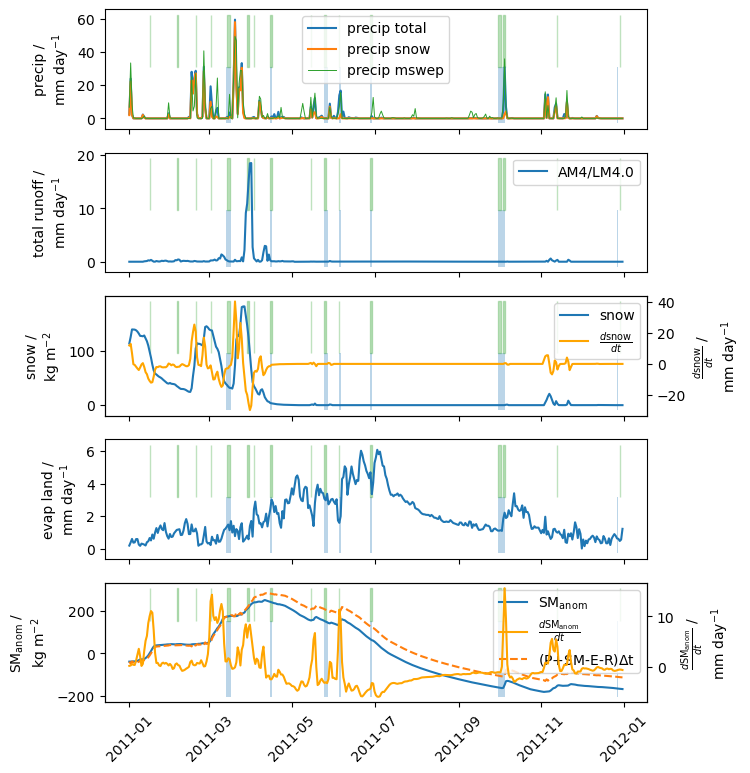

In [7]:
model_data_loc = model_data.sel({'lon': loc_lon, 'lat': loc_lat}, method='nearest')
era5_data_loc = era5_data.sel({'lon': loc_lon, 'lat': loc_lat}, method='nearest')

fig, axs = ara.plot_runoff_timeseries(model_data_loc, era5_data_loc)
# axs[4].set(xlim=[np.datetime64('2005-01-01'), np.datetime64('2005-01-31')])

# fig, axs = ara.plot_runoff_timeseries_sharc(sharc_data, era5_data_loc)
# axs[4].set(xlim=[np.datetime64('2011-03-15'), np.datetime64('2011-04-15')])
plt.savefig(f'/home/Marc.Prange/work/AR-analysis/plots/runoff/sharc_timeseries_providence_catchment_{year}_surfrunoff.png', dpi=300, bbox_inches='tight')

In [5]:
ara.make_movie(
    '/home/Marc.Prange/work/AR-analysis/plots/runoff/precip_AR_shape_map_providence_catchment_*.png', 
    '/home/Marc.Prange/work/AR-analysis/plots/runoff/precip_AR_shape_map_providence_catchment_movie.avi',
    fps=2)

/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The

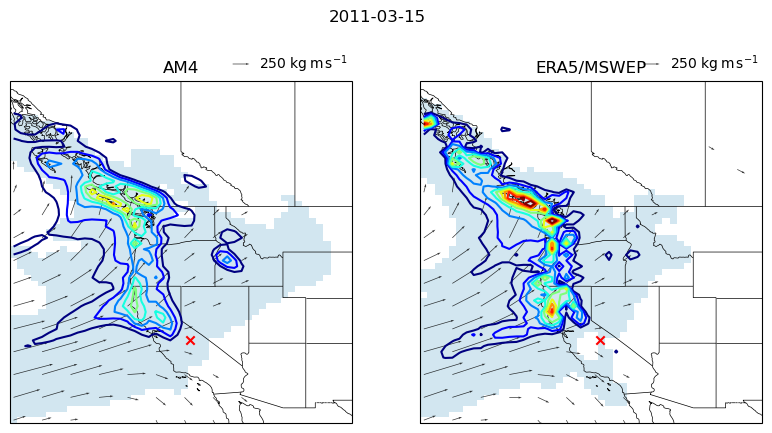

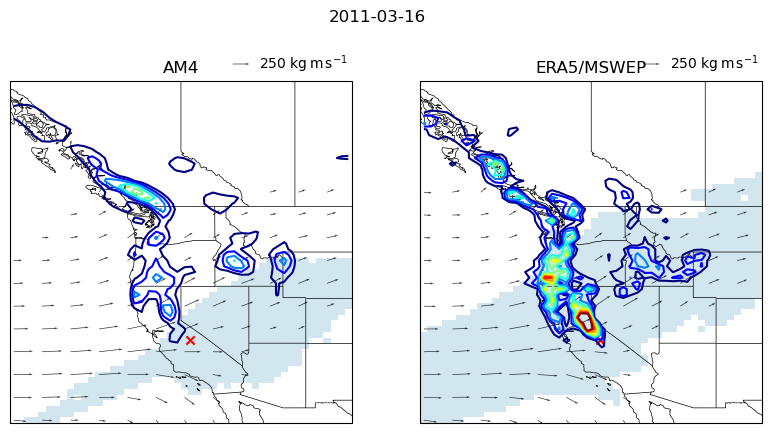

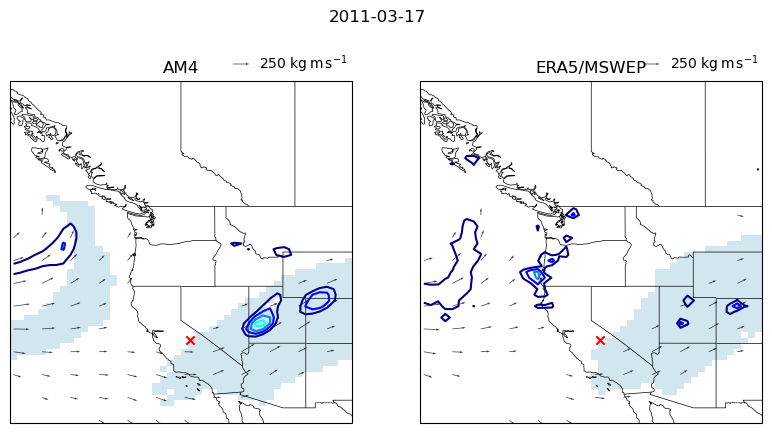

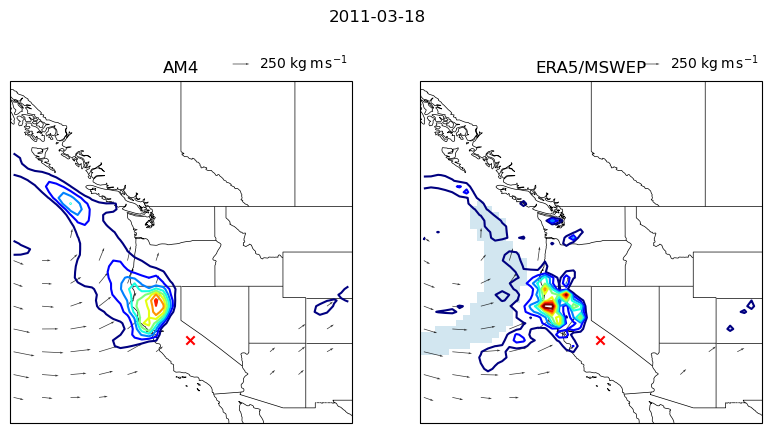

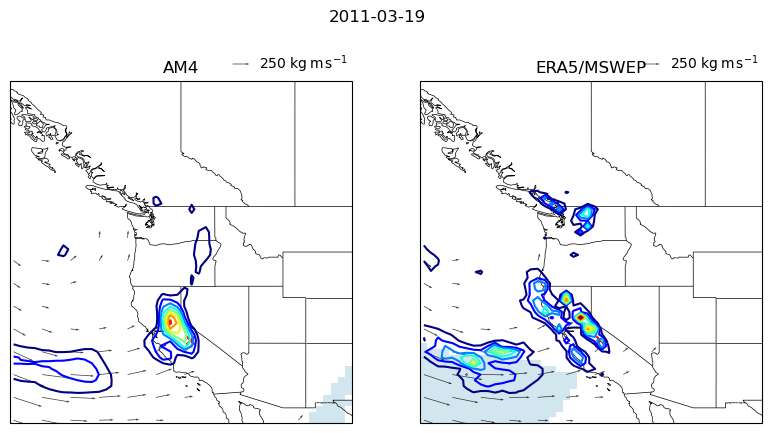

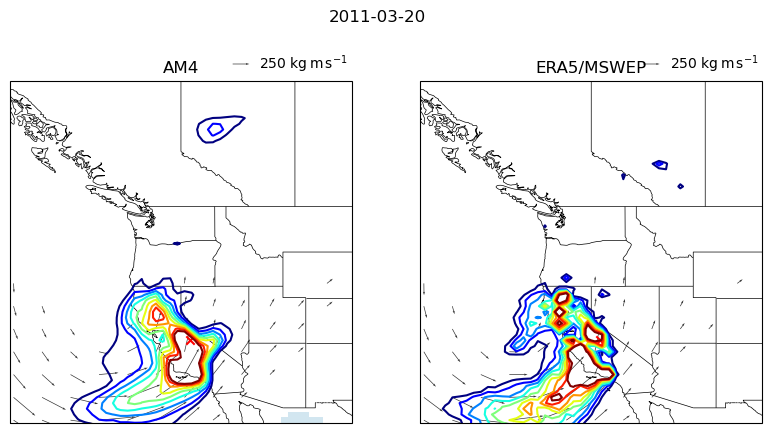

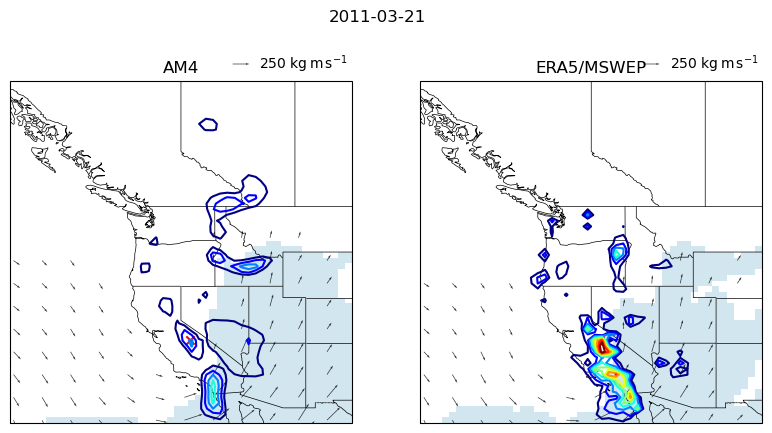

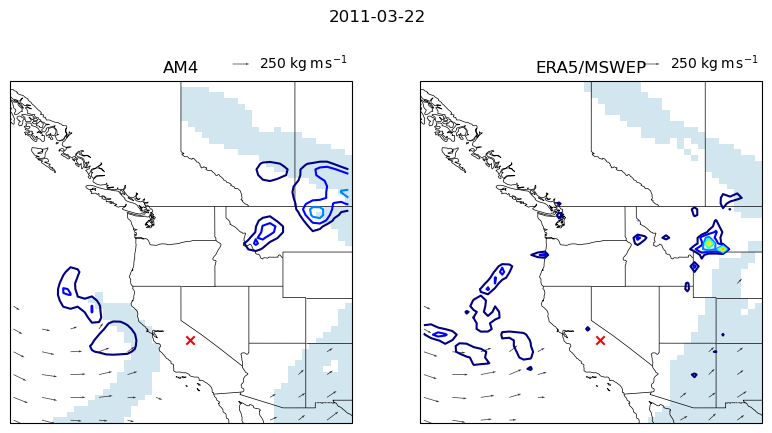

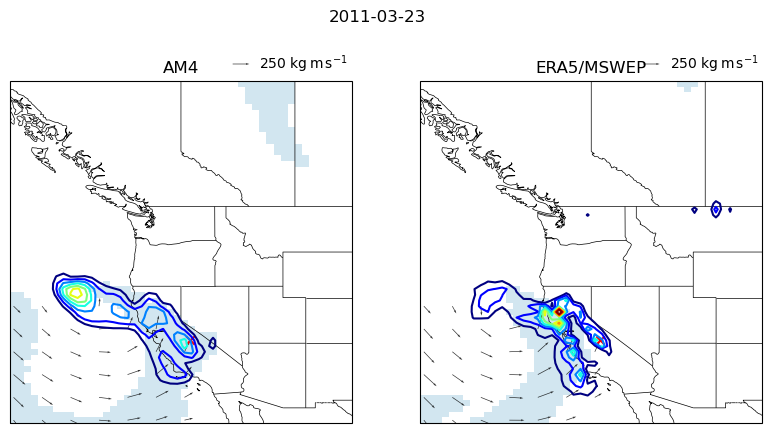

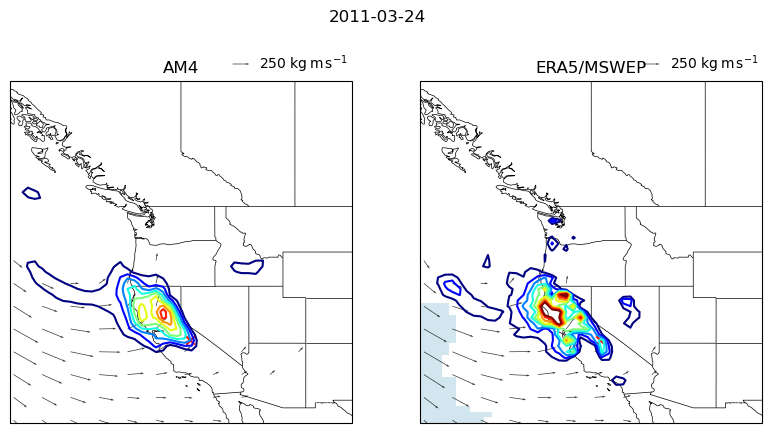

In [18]:
day = '2011-03-20'
for day in np.arange('2011-03-15', '2011-03-25', dtype='datetime64[D]'):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
    fig, ax1 = ara.plot_ivt_ar_shape(fig, ax1, model_data.sel(time=day), rain_contour=True)
    ax1.set(title='AM4')
    ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
    fig, ax2 = ara.plot_ivt_ar_shape(fig, ax2, era5_data.sel(time=day), rain_contour=True)
    ax2.set(title='ERA5/MSWEP')
    fig.suptitle(day, x=0.37)
    for axis in [ax1, ax2]:
        axis.set_extent([-135, -105, 30, 60], crs=ccrs.PlateCarree())
        axis.coastlines("50m", linewidth=0.5)
        # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
        # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
        axis.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        axis.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
        axis.scatter(loc_lon, loc_lat, marker='x', color='red')
    plt.savefig(f'/home/Marc.Prange/work/AR-analysis/plots/runoff/precip_AR_shape_map_providence_catchment_{str(day)}.png', dpi=300, bbox_inches='tight')


In [18]:
np.diff(model_data_loc.snw)-model_data_loc.prsn[:-1]

<xarray.DataArray 'prsn' (time: 364)>
array([-1.20679395e+00, -1.60421753e+00, -1.48461914e+00, -1.63696289e-01,
        1.62030792e+00, -2.42771987e+00, -2.46059302e+00, -5.07633175e+00,
       -1.58966849e+00, -1.14213153e+00, -1.10240253e-01, -6.25353001e-02,
       -1.98005873e-01, -4.59654097e-01, -3.40750720e+00, -5.56668907e+00,
       -5.85799408e+00, -5.58279419e+00, -6.34207916e+00, -6.61560822e+00,
       -6.96400452e+00, -9.60091019e+00, -7.76306152e+00, -2.36719144e+00,
       -2.16624256e+00, -5.70842932e+00, -8.51247184e-01, -7.07410846e-01,
       -2.20027982e+00, -3.21225501e+00, -2.81666946e+00, -2.29899216e+00,
       -1.52885628e+00, -2.16375542e+00, -2.27319145e+00, -1.49454498e+00,
       -7.26328165e-01,  1.16734688e+00, -3.58480003e+00, -1.46478792e+00,
       -5.04130147e-01, -4.54275418e-01, -1.24850464e+00, -1.55137444e+00,
       -1.18261377e+00, -1.51872826e+00, -1.57573891e+00, -9.51611519e-01,
       -7.52249718e-01,  3.59093648e+00, -9.05084177e+00, -2.56988452e+00,
       -1.80895903e+00, -1.25690460e+00, -3.33075165e-01, -1.15983963e+00,
       -1.12460899e+00, -1.36612225e+00, -2.21686459e+00, -3.00198955e+00,
       -2.46952295e+00, -7.22471616e-01, -1.77800093e+00,  1.50939006e+00,
       -4.07258275e+00, -2.25026909e+00, -1.19658383e+00, -5.31882419e+00,
       -6.92953944e-01, -3.26839447e-01, -4.12927330e-01, -4.16544974e-01,
       -1.85606152e-01, -5.40513396e-02, -6.08465075e-02, -5.11754006e-02,
       -5.62230498e-02, -4.76586047e-02, -7.52075154e-01, -2.90268044e-02,
...
        1.57140748e-05, -3.27322835e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.54977897e-09,  5.55883162e-09,
        4.93309926e-09,  0.00000000e+00,  0.00000000e+00,  4.50585503e-07,
       -4.56334416e-02, -2.03055697e+00, -2.57773702e-02,  8.22998481e-05,
        2.04718508e-05,  1.88584982e-05, -7.24782640e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.79480329e-06,
       -3.11762841e-07,  1.80844410e-07,  4.66456728e-02, -1.91190474e+00,
       -1.22024667e+00, -1.01566246e-01, -2.73663870e-02, -2.71790819e-03,
        1.20890327e-04,  3.41978157e-05,  4.98403097e-05,  5.79464706e-04,
       -7.25696472e-02, -1.28870651e-03, -5.78208128e-05,  1.93156209e-02,
       -2.11362870e-01, -2.62987969e-01, -6.46299840e-04,  4.00546645e+00,
       -4.66874733e+00, -3.16283981e-01, -2.12389562e+00, -4.65667534e+00,
       -1.40459740e+00, -3.15110147e-01,  2.26515344e-04,  5.99783380e-04,
        1.00535178e-03,  4.71144216e-04,  1.11475575e-03,  2.41932824e-01,
       -1.66214390e+00, -4.71286394e-01, -8.61634257e-02, -7.27698114e-03,
        2.05567013e-03,  3.44034401e-04,  1.74530200e-04, -6.54378673e-05,
        3.90046043e-05,  7.14129419e-05,  1.44214719e-04,  1.28003187e-04])
Coordinates:
    lat      float64 37.25
    lon      float64 -119.1
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-30